# Model with PyTorch

In [1]:
from brouillon import *

In [2]:
import os
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
import string
import matplotlib.pyplot as plt

### create a class for the dataset

In [3]:
# Chargement des données
dataset = CaptchaDataset(file_path="data/6_CHARACTERS", size_image=(75, 250, 1), ncharacter_per_image=6, ncharacter_total=36)

train_size = len(dataset) - 11600
test_size = 11600
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### create a model

In [4]:
# Création du modèle
model = CaptchaModel(size_image=(75, 250, 1), n_characters_per_image=6, n_characters_total=36)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### train the model

In [5]:
# Listes pour stocker les pertes
train_losses = []
val_losses = []

# Entraînement
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = sum(criterion(output, label) for output, label in zip(outputs, labels.permute(1, 0, 2)))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_loader))

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            loss = sum(criterion(output, label) for output, label in zip(outputs, labels.permute(1, 0, 2)))
            val_loss += loss.item()
    val_losses.append(val_loss / len(test_loader))
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')

Epoch [1/20], Train Loss: 1.3055, Val Loss: 0.7259
Epoch [2/20], Train Loss: 0.9998, Val Loss: 0.7157
Epoch [3/20], Train Loss: 0.9029, Val Loss: 0.6875
Epoch [4/20], Train Loss: 0.8235, Val Loss: 0.6616
Epoch [5/20], Train Loss: 0.7425, Val Loss: 0.5907
Epoch [6/20], Train Loss: 0.6584, Val Loss: 0.5153
Epoch [7/20], Train Loss: 0.5834, Val Loss: 0.4262
Epoch [8/20], Train Loss: 0.5078, Val Loss: 0.3618
Epoch [9/20], Train Loss: 0.4505, Val Loss: 0.3072
Epoch [10/20], Train Loss: 0.4104, Val Loss: 0.2743
Epoch [11/20], Train Loss: 0.3812, Val Loss: 0.2572
Epoch [12/20], Train Loss: 0.3614, Val Loss: 0.2354
Epoch [13/20], Train Loss: 0.3462, Val Loss: 0.2270
Epoch [14/20], Train Loss: 0.3335, Val Loss: 0.2171
Epoch [15/20], Train Loss: 0.3237, Val Loss: 0.2125
Epoch [16/20], Train Loss: 0.3172, Val Loss: 0.2051
Epoch [17/20], Train Loss: 0.3114, Val Loss: 0.1994
Epoch [18/20], Train Loss: 0.3059, Val Loss: 0.1933
Epoch [19/20], Train Loss: 0.3013, Val Loss: 0.1946
Epoch [20/20], Train 

In [6]:
torch.save(model, "model_full_v1.pth")

### plot the loss function

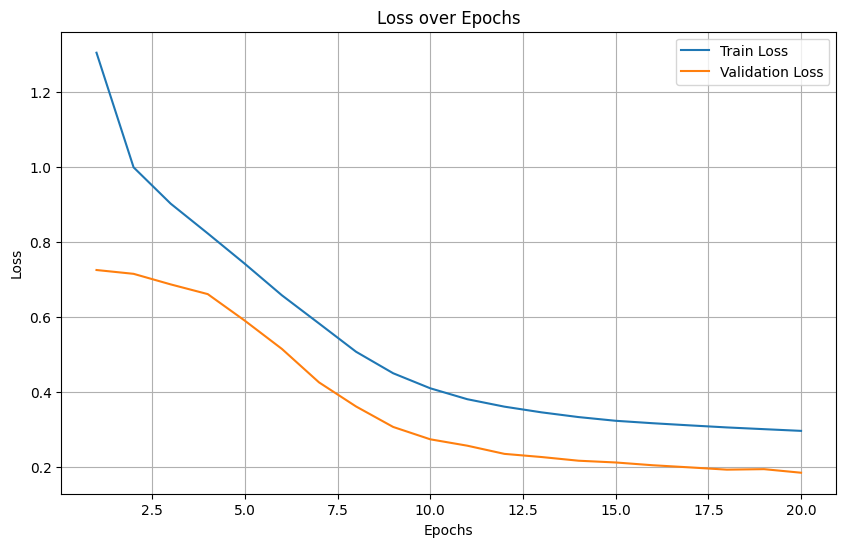

In [7]:
# Tracé des pertes
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [3]:
model = torch.load("model_full_1.pth")
model.eval()

C:\Users\Nasir\AppData\Local\Temp\ipykernel_20476\2030212689.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("model_full_1.pth")


CaptchaModel(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_layers): ModuleList(
    (0-5): 6 x Sequential(
      (0): Linear(in_features=8928, out_features=64, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.5, inplace=False)
      (3): Linear(in_features=64, out_features=36, bias=True)
      (4): Sigmoid()
    )
  )
)

In [ ]:
summary(model, (1, 75, 250))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 16, 75, 250]         160
├─MaxPool2d: 1-2                         [-1, 16, 37, 125]         --
├─Conv2d: 1-3                            [-1, 32, 37, 125]         4,640
├─MaxPool2d: 1-4                         [-1, 32, 18, 62]          --
├─Conv2d: 1-5                            [-1, 32, 18, 62]          9,248
├─MaxPool2d: 1-6                         [-1, 32, 9, 31]           --
├─BatchNorm2d: 1-7                       [-1, 32, 9, 31]           64
├─ModuleList: 1                          []                        --
|    └─Sequential: 2-1                   [-1, 36]                  --
|    |    └─Linear: 3-1                  [-1, 64]                  571,456
|    |    └─ReLU: 3-2                    [-1, 64]                  --
|    |    └─Dropout: 3-3                 [-1, 64]                  --
|    |    └─Linear: 3-4                  [-1, 36]                  2,340


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 16, 75, 250]         160
├─MaxPool2d: 1-2                         [-1, 16, 37, 125]         --
├─Conv2d: 1-3                            [-1, 32, 37, 125]         4,640
├─MaxPool2d: 1-4                         [-1, 32, 18, 62]          --
├─Conv2d: 1-5                            [-1, 32, 18, 62]          9,248
├─MaxPool2d: 1-6                         [-1, 32, 9, 31]           --
├─BatchNorm2d: 1-7                       [-1, 32, 9, 31]           64
├─ModuleList: 1                          []                        --
|    └─Sequential: 2-1                   [-1, 36]                  --
|    |    └─Linear: 3-1                  [-1, 64]                  571,456
|    |    └─ReLU: 3-2                    [-1, 64]                  --
|    |    └─Dropout: 3-3                 [-1, 64]                  --
|    |    └─Linear: 3-4                  [-1, 36]                  2,340


###  test the model on the test dataset

In [ ]:
characters = string.ascii_uppercase + string.digits
model.eval()
truepos = 0
count_img = 0
for images, labels in test_dataset:
    # print(images.shape)
    # print(labels.shape)
    # print(images)
    # print(model(images.unsqueeze(0)))
    prediction = predict(model, images)
    labels = [characters[torch.argmax(la).item()] for la in labels]
    if sum(p == g for p, g in zip(prediction, labels)) != 6:
        count_img += 1
    #     print(prediction)
    #     print(labels)
    truepos += sum(p == g for p, g in zip(prediction, labels))
    

Accuracy = truepos/(len(test_dataset)*6)
Accuracy_v1 = (len(test_dataset)-count_img)/len(test_dataset)

In [9]:
def predict(model, images):
    characters = string.ascii_uppercase + string.digits
    model.eval()
    predictions = model(images.unsqueeze(0))
    return[characters[torch.argmax(p, dim=1).item()] for p in predictions]


### Result

In [17]:
print(f"l'accuracy sur les caractères est de {Accuracy}")
print(f"le nombre d'image qui ont au moins un caractère incorrect est de {count_img}") #count_img
print(f"l'autre accuracy sur les images est de {Accuracy_v1}") 

l'accuracy sur les caractères est de 0.8610057471264367
le nombre d'image qui ont au moins un caractère incorrect est de 5327
l'autre accuracy sur les images est de 0.5407758620689656
